<a href="https://colab.research.google.com/github/123ranika/jsfinal/blob/main/FacebookAI_xlm_roberta_base_run_9250_error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Performing checks for the resources available

In [189]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Installing huggingface transformers library

In [190]:
!pip install transformers

## Importing necessary packages

In [191]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import time
import datetime
from sklearn.metrics import classification_report,confusion_matrix
import random
import time
import torch.nn as nn
from transformers import AutoModel , AutoModelForSequenceClassification, AutoConfig , AutoTokenizer , AdamW ,get_linear_schedule_with_warmup
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

## Setting some configuration values

In [192]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,12)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Importing drive into the colaboratory

In [193]:
# from google.colab import drive
# drive.mount('/content/drive')

## Loading training data

In [194]:
import pandas as pd

# Attempt to read the file with ISO-8859-1 encoding
data = pd.read_excel('/content/Dataset (3).xlsx')


In [195]:
data=data[:9250]

In [196]:
data.count()

,0
texts,9249
labels,9250


In [197]:
data.head()

,texts,labels
0,মেধাবী শিক্ষার্থীরাই মা বাবাকে বিদ্যাস্রমে পাটাবে,Cyberbullying
1,চিরিয়া খানার এই অদ্ভুত প্রাণী গুলারে রাস্তায়...,Cyberbullying
2,শরীর বিক্রি করে পয়সা কামাই করে৷ আবার ভাব কি,Cyberbullying
3,এটা কি আমাদের ধর্মজাল,Religious_Hatred
4,বেডি আসার আগে দাঁত মাজতে ভুলে গেছে বুঝি।,Cyberbullying


In [198]:
# Add an ID column starting from 1
data['PID'] = range(1, len(data) + 1)

In [199]:
data.head()

,texts,labels,PID
0,মেধাবী শিক্ষার্থীরাই মা বাবাকে বিদ্যাস্রমে পাটাবে,Cyberbullying,1
1,চিরিয়া খানার এই অদ্ভুত প্রাণী গুলারে রাস্তায়...,Cyberbullying,2
2,শরীর বিক্রি করে পয়সা কামাই করে৷ আবার ভাব কি,Cyberbullying,3
3,এটা কি আমাদের ধর্মজাল,Religious_Hatred,4
4,বেডি আসার আগে দাঁত মাজতে ভুলে গেছে বুঝি।,Cyberbullying,5


In [200]:
import pandas as pd

# Function to rename a single column
def change_column_name(df, old_name, new_name):
    df = df.rename(columns={old_name: new_name})
    return df

# Assuming df is your DataFrame
data = change_column_name(data, old_name="label", new_name="labels")
data = change_column_name(data, old_name="Comments", new_name="text")
data.head() # Display the first few rows of the DataFrame
#text


# Move the ID column to the first position
cols = ['PID'] + [col for col in data.columns if col != 'PID']
data = data[cols]

data.head()

,PID,texts,labels
0,1,মেধাবী শিক্ষার্থীরাই মা বাবাকে বিদ্যাস্রমে পাটাবে,Cyberbullying
1,2,চিরিয়া খানার এই অদ্ভুত প্রাণী গুলারে রাস্তায়...,Cyberbullying
2,3,শরীর বিক্রি করে পয়সা কামাই করে৷ আবার ভাব কি,Cyberbullying
3,4,এটা কি আমাদের ধর্মজাল,Religious_Hatred
4,5,বেডি আসার আগে দাঁত মাজতে ভুলে গেছে বুঝি।,Cyberbullying


In [201]:


# Keep only the specified three columns
# Replace 'column1', 'column2', 'column3' with your actual column names
data = data[['PID', 'texts', 'labels']]

# Report the number of sentences
print('Number of training sentences: {:,}\n'.format(data.shape[0]))

# Display 10 random rows from the data
print(data.sample(10))


Number of training sentences: 9,250

       PID                                              texts  \
586    587                          হুংকার গারে গুঁজে দিয়েছে   
2473  2474                                  বাহ চুদির ভাই বাহ   
7145  7146    বউয়ের শাড়ী খুলেও যেন খুলছে না...কী একটা অবস্থা    
3542  3543                              আপা আমারে দেখতে পারেন   
3063  3064                         স্যার কমেন্টের সবই রাজাকার   
1145  1146                মেয়েটার এক্সপ্রেশন বলে দেয় ও আনাড়ি,   
6144  6145                       কাওয়ালির কাছে তোমরা ফ্লপ...   
8840  8841                           এই খানকিরে দেখলে বমি আসে   
620    621  ফারিন অনেক মজার কিন্তু তার নাটক দেখলে বুঝা যায় না   
6065  6066                       প্রশাসন কি দায়িত্ব পালন করছে   

                     labels  
586                 Sarcasm  
2473          Cyberbullying  
7145  Gender_Discrimination  
3542                Sarcasm  
3063              Political  
1145                Sarcasm  
6144                Sarcasm  
8840  G

In [202]:
import pandas as pd
from sklearn.model_selection import train_test_split

# # Read the file with ISO-8859-1 encoding
# train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Nazir Sir/spam - spam.csv', encoding='ISO-8859-1')

# First, split the data into training and temp (test + validation)
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=42)

# Then split temp_data into test and validation sets (50% each of temp_data, so 15% of the total for each)
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [203]:
train_df

,PID,texts,labels
8329,8330,আবার কবে শুরু হবে কুকুরমালাও খানকি মালা,Cyberbullying
2301,2302,মুক্তিযুদ্ধা ছাড়া বাকিরা রাজাকার,Political
7672,7673,"তোর ধর্মে কিছু নেই, সব বাজে।",Religious_Hatred
1701,1702,মিরাজের ভিটামিনের পাওয়ার,Sarcasm
2518,2519,শকুনের দৃষ্টি পড়েছে মুক্তি যোদ্ধা কোটার উপর,Political
...,...,...,...
5734,5735,কুত্তা লীগ,Cyberbullying
5191,5192,এখন নাচতে শুরু করেছে পরে বাঁচতে শুরু করবে,Sarcasm
5390,5391,পাগোল যদি মাঠে থাকে তাহলে বিবাহ হবেনানে,Sarcasm
860,861,অতি টিপার ফল,Cyberbullying


In [204]:
test_df

,PID,texts,labels
7345,7346,গণ বিবাহতে আপা ও ছিলো। আপারে দেখতে অনেক কিউট ল...,Gender_Discrimination
8290,8291,পোলার গুষ্টিরে কুমিল্লার মানুষে করছে,Racism
1126,1127,তোর বাপের সাথে সংসার থাকলে ভেঙ্গে তো যাবেই!,Cyberbullying
2275,2276,ঘুমাইলাম কাম শেষ হইলে আমারে ডাক দিস,Sarcasm
9215,9216,জয় বাংলা তোর নানীর পুটকি সামলা,Gender_Discrimination
...,...,...,...
7695,7696,তুই একটা হারামির বাচ্চা।,Cyberbullying
4993,4994,বিবিসি তখন ধর্মহীনতার প্রতি উৎসাহিত করছে,Cyberbullying
9248,9249,মিম এখন টয়লেটেমিম এখন টয়লেটে,Gender_Discrimination
2698,2699,সরকার কেগদি থেকে রাস্তায় নামার আন্দোলন,Political


In [205]:
val_df

,PID,texts,labels
1038,1039,আমাগোরে গার্ড স্যারেই কাপায় দিছে,Sarcasm
7831,7832,তোর জাতি সবসময় সমস্যার সৃষ্টি করে।,Racism
5563,5564,যু্দ্ধ করবো ভারতের বিরুদ্ধে,Political
1595,1596,এ হুজুরের পামু কোন জায়গায় খানকির পোলার কানসা...,Cyberbullying
2906,2907,এতেরে ডিম থেরাপি দিতে হবে,Sarcasm
...,...,...,...
7078,7079,ভারতীয় এনিমেল... \nপাপা পাপা পাপা পাপা পাপা পা...,Gender_Discrimination
8782,8783,মাগি তুরে কুত্তা দিয়া চুদান উচিত,Cyberbullying
4680,4681,ফতোয়া দেওয়া স্বৈরাচারের মতোই তো বর্তমানদের আচরণ,Political
2680,2681,আল্লাহ পাক তাহাকে জান্নাতুল টুঙ্গিপাড়া দান করুন,Sarcasm


In [206]:
train_df['labels'].value_counts()

,count
labels,
Cyberbullying,2010
Sarcasm,1923
Political,978
Religious_Hatred,887
Gender_Discrimination,806
Racism,796


In [207]:

le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['labels'])

In [208]:
train_df['labels'].value_counts()

,count
labels,
0,2010
5,1923
2,978
4,887
1,806
3,796


### Loading `train_sentences` and `train_labels`

In [209]:
# Get the lists of sentences and their labels.
train_sentences = train_df['texts'].values
train_labels = train_df['labels'].values

## Saving Class Names

In [210]:
data.labels.unique()

array(['Cyberbullying', 'Religious_Hatred', 'Gender_Discrimination',
       'Sarcasm', 'Political', 'Racism'], dtype=object)

In [211]:
class_names = [
            'Cyberbullying', 'Religious_Hatred', 'Gender_Discrimination',
       'Sarcasm', 'Political', 'Racism'
]

## Loading the validation data

In [212]:
val_df['labels'] = le.transform(val_df['labels'])

In [213]:

val_df['labels'].value_counts()

,count
labels,
0,228
5,215
2,155
4,116
1,112
3,99


### Loading `val_sentences` and `val_labels`

In [214]:
# Get the lists of sentences and their labels.
val_sentences = val_df['texts'].values
val_labels = val_df['labels'].values

In [215]:
val_labels

array([5, 3, 2, 0, 5, 4, 3, 0, 1, 0, 4, 4, 3, 4, 5, 3, 5, 1, 0, 1, 3, 0,
       3, 1, 0, 0, 0, 5, 2, 1, 4, 1, 1, 4, 5, 2, 0, 0, 0, 5, 2, 5, 5, 1,
       5, 5, 3, 0, 5, 0, 4, 3, 1, 0, 3, 0, 5, 0, 5, 2, 5, 0, 3, 2, 3, 5,
       5, 2, 2, 4, 5, 5, 5, 5, 3, 1, 5, 4, 4, 5, 0, 0, 4, 1, 3, 4, 2, 2,
       0, 2, 4, 0, 5, 2, 0, 3, 5, 4, 5, 2, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0,
       2, 4, 2, 5, 4, 3, 0, 4, 3, 2, 2, 4, 5, 5, 0, 0, 0, 5, 2, 4, 1, 2,
       1, 5, 5, 2, 0, 4, 5, 0, 2, 0, 3, 4, 0, 1, 5, 0, 5, 0, 0, 0, 5, 1,
       5, 1, 5, 5, 0, 2, 3, 0, 0, 2, 0, 1, 0, 0, 1, 4, 5, 5, 2, 2, 0, 0,
       3, 1, 1, 4, 0, 5, 1, 5, 5, 2, 2, 4, 0, 5, 0, 2, 5, 1, 0, 0, 0, 2,
       3, 2, 5, 0, 0, 5, 3, 1, 2, 5, 5, 2, 5, 1, 5, 5, 0, 5, 0, 0, 5, 0,
       5, 2, 3, 4, 0, 1, 1, 0, 2, 1, 0, 4, 0, 0, 0, 2, 2, 1, 1, 1, 2, 0,
       3, 5, 0, 0, 5, 1, 5, 2, 1, 2, 2, 2, 0, 2, 3, 3, 3, 2, 0, 2, 3, 1,
       3, 0, 0, 1, 5, 5, 3, 5, 3, 4, 0, 0, 5, 0, 5, 4, 2, 1, 0, 0, 0, 3,
       5, 2, 1, 4, 2, 2, 2, 3, 5, 0, 5, 5, 1, 4, 3,

## Helper Functions

#### 1) Update Interval Function

In [216]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

#### 2) Format time function

In [217]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### 3) Make Smart Batches function

In [218]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


In [219]:
def make_smart_batches_on_test(text_samples, text_ids, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(text_samples)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(text_samples), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, text_ids), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_ids = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_ids.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_ids = []

    # For each batch...
    for (batch_inputs, batch_ids) in zip(batch_ordered_sentences, batch_ordered_ids):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_ids.append(torch.tensor(batch_ids))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_ids)


#### 4) Function for calculating accuracy per class

In [220]:
def accuracy_per_class(preds, labels , label_dict):

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict[label]}')
        print(f'Accuracy: {round(100*len(y_preds[y_preds==label])/len(y_true) , 2)}\n')

### 5) Function for plotting training history

In [221]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

### 6) Function to check accuracy

In [222]:
def check_accuracy(predictions,true_labels):
  # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  # Calculate simple flat accuracy -- number correct over total number.
  accuracy = (preds == true_labels).mean()

  return accuracy

### 7) Function to evaluate model

In [223]:
def eval_model(model,py_inputs, py_attn_masks, py_labels):
# Prediction on test set
  t0 = time.time()

  print('Doing validation on {:,} sentences...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()
  total_val_loss = 0

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
        output = model(b_input_ids,
                           #  token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)


      logits = output.logits
      loss = output.loss
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

      total_val_loss += loss.item()

  val_accuracy = check_accuracy(predictions,true_labels)

  validation_time = format_time(time.time() - t0)

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_val_loss / len(py_inputs)


  # print('Accuracy: {:.3f}'.format(val_accuracy))
  return (avg_val_loss,val_accuracy,validation_time)


### 8) Function for making predictions on our test dataset

In [224]:
def get_predictions(py_inputs, py_attn_masks, py_labels):

  print('Predicting labels for {:,} test batches...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

      # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return (preds,true_labels)

### 9) Function for making predictions on test dataset(without labels)

In [225]:
def get_predictions_test(py_inputs, py_attn_masks,py_ids):

  print('Predicting labels for {:,} test batches...'.format(len(py_inputs)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels ,ids = [], [] , []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_ids = py_ids[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      b_ids = b_ids.detach().cpu().numpy()
      # Store predictions
      predictions.append(logits)
      ids.append(b_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  ids = np.concatenate(ids,axis=0)
  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return ids,preds

### 10) Confusion Matrix Helper Function

In [226]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

## Smart Batching of the training data

In [227]:
#model_name = 'sagorsarker/bangla-bert-base'

#model_name = 'google-bert/bert-base-multilingual-cased'

#model_name = 'distilbert/distilbert-base-uncased'

model_name = 'FacebookAI/xlm-roberta-base'

#
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Loading FacebookAI/xlm-roberta-base tokenizer...


In [228]:
lengths = []
for text in train_sentences:
  lengths.append(len(text))

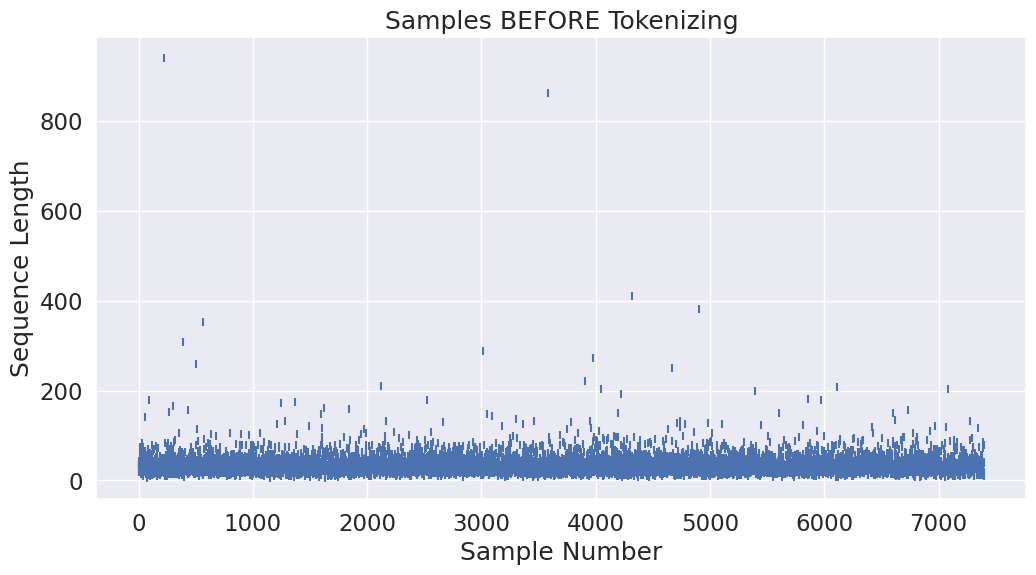

In [229]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

### Tokenizing the sequences

In [230]:
max_input_length = 300

In [231]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:

    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,
                                 add_special_tokens=True,
                                 max_length=max_input_length,
                                 truncation=True,
                                 padding=False)

    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)

print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 7,400 training samples...
  Tokenized 0 samples.
  Tokenized 700 samples.
  Tokenized 1,400 samples.
  Tokenized 2,100 samples.
  Tokenized 2,800 samples.
  Tokenized 3,500 samples.
  Tokenized 4,200 samples.
  Tokenized 4,900 samples.
  Tokenized 5,600 samples.
  Tokenized 6,300 samples.
  Tokenized 7,000 samples.
DONE.
     7,400 samples


In [232]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

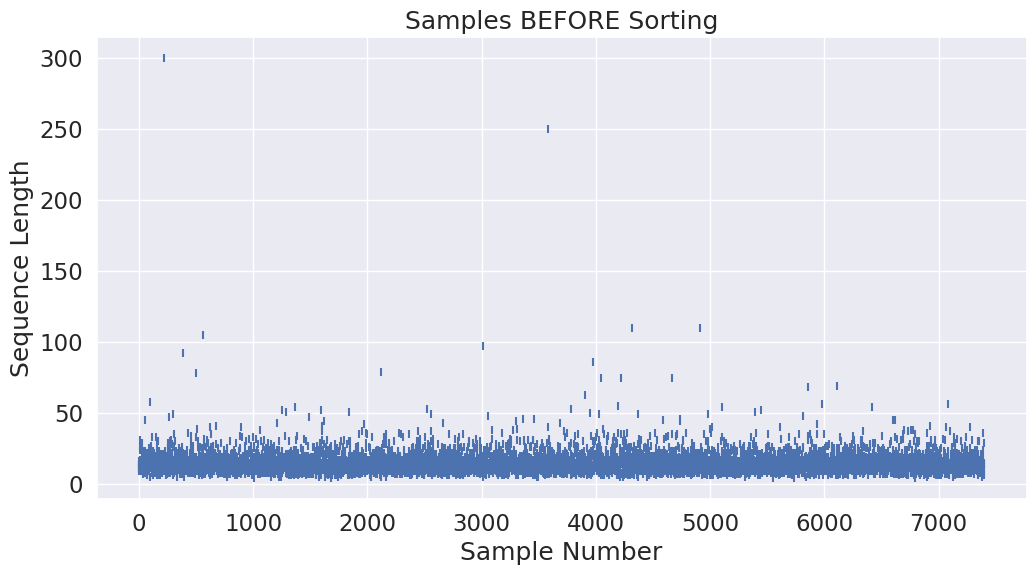

In [233]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [234]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [235]:
train_samples[0:5]

[([0, 240897, 223551, 2], 0),
 ([0, 128474, 176570, 2], 5),
 ([0, 127205, 9591, 2], 5),
 ([0, 127205, 47193, 2], 5),
 ([0, 190186, 47193, 2], 0)]

In [236]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 4
Longest sample: 300


In [237]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

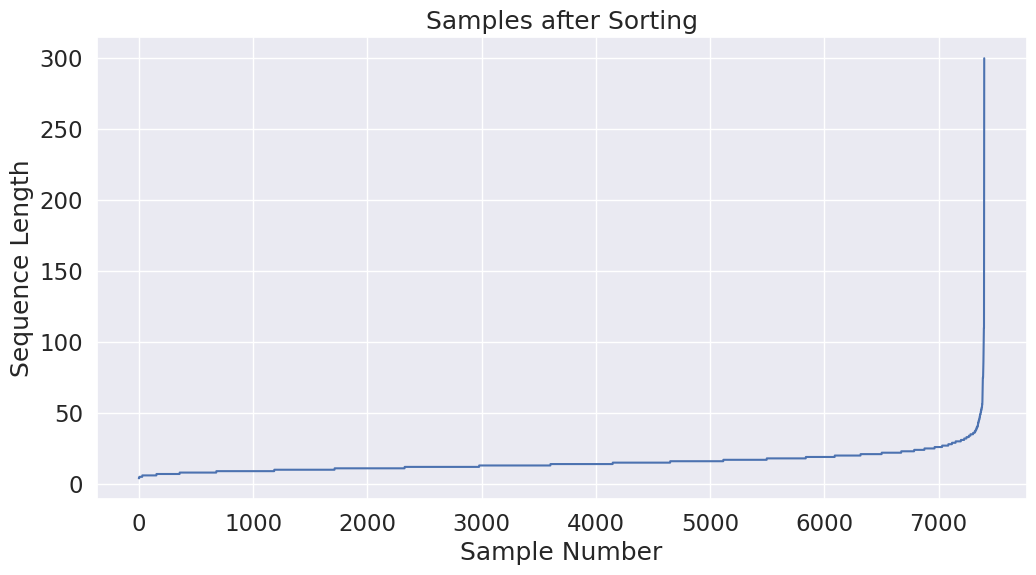

In [238]:


plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

### Random Batch Selections

In [239]:
train_samples[0]

([0, 240897, 223551, 2], 0)

In [240]:
batch_size = 16

In [241]:
# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...
while len(train_samples) > 0:

    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until
    # we get to the last batch, which may be smaller.
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.
  Selected 200 batches.
  Selected 300 batches.
  Selected 400 batches.

  DONE - 463 batches.


In [242]:
print(batch_ordered_sentences[0])

[[0, 60910, 11291, 3397, 92730, 4691, 8377, 84584, 152596, 44201, 60910, 11291, 74670, 4876, 82712, 41819, 2], [0, 16447, 16576, 4876, 122493, 51121, 67026, 3718, 29388, 6638, 4876, 62429, 232388, 30414, 32568, 210749, 2], [0, 90830, 9307, 37564, 7212, 3397, 9976, 5521, 81474, 7185, 23456, 155189, 2114, 9755, 86780, 41758, 2], [0, 122474, 13926, 122474, 50321, 62820, 11785, 8619, 956, 86822, 42854, 7277, 100564, 47668, 999, 125, 2], [0, 38254, 104797, 60546, 172909, 20404, 9755, 113550, 956, 31696, 50365, 31696, 26172, 124432, 10814, 42776, 2], [0, 6, 115711, 87317, 47448, 67734, 12229, 32368, 97393, 90830, 87317, 91605, 34727, 2784, 47857, 4876, 2], [0, 6, 109950, 55820, 44056, 26782, 62429, 6, 46803, 3495, 212060, 104157, 2730, 130327, 4691, 36283, 2], [0, 21431, 17063, 9, 7163, 9853, 37982, 7185, 209591, 229264, 81385, 30234, 34545, 40449, 4480, 125, 2], [0, 4979, 91975, 956, 16209, 98715, 14510, 113547, 41315, 6, 46803, 12814, 57732, 53997, 30414, 15709, 2], [0, 226590, 124805, 217

In [243]:
batch_ordered_labels[0]

[0, 5, 3, 5, 5, 5, 0, 0, 0, 1, 0, 4, 0, 0, 4, 5]

### Padding

In [244]:
py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []

    # First, find the longest sample in the batch.
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:

        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


### Check the number of token reductions because of smart batching

In [245]:
# Get the new list of lengths after sorting.

padded_lengths = []

# For each batch...
for batch in py_inputs:

    # For each sample...
    for s in batch:

        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count)

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 2,220,000
  Smart Batching: 117,536  (94.7% less)


## Load the model configuration from the transformers library using AutoConfig

In [246]:
# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name,
                                    num_labels=6)

print('Config type:', str(type(config)), '\n')


Config type: <class 'transformers.models.xlm_roberta.configuration_xlm_roberta.XLMRobertaConfig'> 



In [247]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name,config = config)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [248]:
model.cuda()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

## Load the model from the transformers library using AutoModel

In [249]:
# Load the pre-trained model for classification, passing in the `config` from
# above.
bert = AutoModel.from_pretrained(
    pretrained_model_name_or_path=model_name,
    config=config)

print('\nModel type:', str(type(bert)))



Model type: <class 'transformers.models.xlm_roberta.modeling_xlm_roberta.XLMRobertaModel'>


In [250]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Creating a custom BERT model

In [251]:

# class BERT_Model(nn.Module):
#     ## defining the constructor for the class
#     def __init__(self, bert,num_labels):
#       ## calling the super class constructor
#       super(BERT_Model, self).__init__()
#       ## adding the bert layer to the model
#       self.bert = bert
#       # relu activation function
#       self.relu =  nn.ReLU()
#       # adding a dense layer to our custom model
#       self.fc1 = nn.Linear(768,512)
#       # adding another dense layer to our custom model ,i.e., the Output layer
#       self.fc2 = nn.Linear(512,num_labels)
#       # adding a softmax  activation function for our custom model's output layer
#       self.softmax = nn.LogSoftmax(dim=1)

#     #defining the forward pass
#     def forward(self, input_id, mask):
#       #pass the inputs to the model
#       outputs = self.bert(input_id,mask)

#       last_hidden_state = outputs.last_hidden_state       ## last hidden state from the model
#       pooler_output = outputs.pooler_output               ## pooler output from the model
#       ## adding a fully connected layer to the BERT model
#       x = self.fc1(pooler_output)
#       ## applying relu activation function
#       x = self.relu(x)
#       # the final output layer
#       x = self.fc2(x)
#       # apply softmax activation to our output layer
#       x = self.softmax(x)

#       return x

In [252]:


# print('\nLoading model ...')
# # pass the pre-trained BERT to our define architecture
# model = BERT_Model(bert,num_labels=3)

# model.cuda()

## Custom Loss function

In [253]:
# # convert class weights to tensor
# weights= torch.tensor(class_wts,dtype=torch.float)
# weights = weights.to(device)

# # loss function
# cross_entropy  = nn.NLLLoss(weight=weights)


## Loading Optimizer

In [254]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Loading lr scheduler

In [255]:
# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 20

# Total number of training steps is [number of batches] x [number of epochs].
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [256]:
# import numpy as np
# from sklearn.preprocessing import LabelEncoder

# # Check if all validation labels are present in the training labels
# missing_labels = set(val_labels) - set(train_labels)

# if missing_labels:
#     print(f"Warning: The following labels in validation data were not seen in the training data: {missing_labels}")
#     # Optionally, you could handle missing labels here, either by filtering or adding them to the encoder.
# else:
#     # Convert validation labels using the same LabelEncoder to ensure the mapping is consistent
#     val_labels_encoded = label_encoder.transform(val_labels)

# # Now continue with the rest of the training as planned.


## Training Loop

In [257]:
import time
import torch
from sklearn.preprocessing import LabelEncoder

# Assuming your labels are strings like 'ham' and 'spam', we first fit the LabelEncoder on the training labels
label_encoder = LabelEncoder()

# Convert training labels to numeric values
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Convert validation labels using the same LabelEncoder to ensure the mapping is consistent
val_labels_encoded = label_encoder.transform(val_labels)

# Now, we can proceed with the rest of the code for training and validation.

# We'll store a number of quantities such as training and validation loss, validation accuracy, and timings.
training_stats = {
    'epoch': [],
    'train_loss': [],
    'Training Time': [],
    'val_loss': [],
    'Validation Time': [],
    'train_acc': [],
    'val_acc': []
}

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    predictions = []
    true_labels = []

    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')

    if epoch_i > 0:
        # Re-shuffle the dataset into new batches
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels_encoded, batch_size, tokenizer, max_input_length)

    print(f'Training on {len(py_inputs):,} batches...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step in range(0, len(py_inputs)):

        if step % update_interval == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            remaining_sec = (time.time() - t0) / step * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)
            print(f'  Batch {step:>7,} of {len(py_inputs):>7,}. Elapsed: {elapsed}. Remaining: {remaining}')

        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        model.zero_grad()
        output = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        #output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output.loss
        logits = output.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(py_inputs)
    training_accuracy = check_accuracy(predictions, true_labels)
    training_time = format_time(time.time() - t0)

    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training Accuracy: {training_accuracy:.2f}")
    print(f"  Training epoch took: {training_time}")

    # Validation
    (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels_encoded, batch_size, tokenizer, max_input_length)
    val_loss, val_accuracy, validation_time = eval_model(model, py_inputs, py_attn_masks, py_labels)

    # (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels_encoded, batch_size,  max_input_length)
    # val_loss, val_accuracy, validation_time = eval_model(model, py_inputs, py_attn_masks, py_labels)

    print("")
    print(f"  Average validation loss: {val_loss:.2f}")
    print(f"  Validation Accuracy: {val_accuracy:.2f}")
    print(f"  Validation epoch took: {validation_time}")

    # Record all statistics from this epoch.
    training_stats['epoch'].append(epoch_i + 1)
    training_stats['train_loss'].append(avg_train_loss)
    training_stats['Training Time'].append(training_time)
    training_stats['val_loss'].append(val_loss)
    training_stats['Validation Time'].append(validation_time)
    training_stats['train_acc'].append(training_accuracy)
    training_stats['val_acc'].append(val_accuracy)

print("")
print(f"Training complete! Total training took {format_time(time.time() - total_t0)} (h:mm:ss)")



======== Epoch 1 / 20 ========
Training on 463 batches...
  Batch      50 of     463. Elapsed: 0:00:07. Remaining: 0:00:56
  Batch     100 of     463. Elapsed: 0:00:14. Remaining: 0:00:49
  Batch     150 of     463. Elapsed: 0:00:21. Remaining: 0:00:43
  Batch     200 of     463. Elapsed: 0:00:27. Remaining: 0:00:36
  Batch     250 of     463. Elapsed: 0:00:34. Remaining: 0:00:29
  Batch     300 of     463. Elapsed: 0:00:41. Remaining: 0:00:22
  Batch     350 of     463. Elapsed: 0:00:48. Remaining: 0:00:15
  Batch     400 of     463. Elapsed: 0:00:55. Remaining: 0:00:09
  Batch     450 of     463. Elapsed: 0:01:02. Remaining: 0:00:02
  Average training loss: 1.41
  Training Accuracy: 0.45
  Training epoch took: 0:01:04
Creating Smart Batches from 925 examples with batch size 16...

Tokenizing 925 samples...
  Tokenized 0 samples.


TypeError: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]

In [ ]:
plot_training_history(training_stats)

## Evaluating Performance Over Training Set

In [ ]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)


In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Evaluating Performance Over Validation Set

In [ ]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Making Predictions on Test Set

In [ ]:
test_df

## Loading `test_sentences`

In [ ]:
test_sentences = test_df['texts'].values
test_labels = test_df['labels'].values
test_ids = test_df.index.values

In [ ]:
test_ids

In [ ]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)

In [ ]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


In [ ]:
test_sentences

In [ ]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)
y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

In [ ]:
y_pred

## Evaluating accuracy over test set

In [ ]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


In [ ]:
print(y_preds)

In [ ]:
print(y_ids)

In [ ]:
le.inverse_transform(y_preds)

In [ ]:
sns.countplot(y =le.inverse_transform(y_preds))

In [ ]:
len(y_ids)

In [ ]:
y_pred=le.inverse_transform(y_preds)
y_pred